# Understanding Latent Space in Normalizing Flows (PyTorch)

This notebook demonstrates how normalizing flows use **latent space** to transform simple Gaussian distributions into complex target distributions.

We'll use **PyTorch** to build a proper normalizing flow with:
- Real coupling layers
- Automatic differentiation
- Proper training with gradient descent

## What We'll Show:
1. **Latent Space (z)**: Simple 2D Gaussian - easy to sample from
2. **Data Space (x)**: Complex 2D bimodal distribution - what we want
3. **The Flow**: Neural network that maps z → x
4. **Training**: How the flow learns this mapping
5. **Sampling**: How we generate new samples using latent space

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# Use CPU
device = torch.device('cpu')

print("✓ Imports complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

✓ Imports complete!
PyTorch version: 2.9.0+cpu
Device: cpu


## Part 1: Build the Coupling Layer

A coupling layer is the building block of normalizing flows. It:
1. Splits input into two parts
2. Keeps one part unchanged
3. Transforms the other part using a neural network
4. Is **invertible** by design!

In [2]:
class CouplingLayer(nn.Module):
    """
    Affine coupling layer for normalizing flows.
    
    Given input z = [z1, z2]:
    - x1 = z1 (unchanged)
    - x2 = z2 * exp(s(z1)) + t(z1)  (transformed)
    
    where s and t are neural networks.
    """
    
    def __init__(self, dim, hidden_dim=128, mask_type='half'):
        super().__init__()
        self.dim = dim
        
        # Create mask (which dimensions to keep unchanged)
        mask = torch.zeros(dim)
        mask[:dim//2] = 1
        self.register_buffer('mask', mask)
        
        # Scale network (s)
        self.scale_net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, dim),
            nn.Tanh()  # Bound output to [-1, 1], then scale
        )
        
        # Translation network (t)
        self.translate_net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, dim)
        )
        
        # Scale factor for numerical stability
        self.scale_factor = 2.0
    
    def forward(self, z):
        """
        Forward: LATENT SPACE (z) → DATA SPACE (x)
        
        Returns:
            x: transformed samples
            log_det: log determinant of Jacobian
        """
        # Apply mask to get the unchanged part
        z_masked = z * self.mask
        
        # Compute scale and translation
        s = self.scale_net(z_masked) * self.scale_factor  # Scale output
        t = self.translate_net(z_masked)
        
        # Apply transformation: x = z * exp(s) + t for masked dimensions
        x = z * self.mask + (1 - self.mask) * (z * torch.exp(s) + t)
        
        # Log determinant is sum of scales (only for transformed dimensions)
        log_det = torch.sum((1 - self.mask) * s, dim=1)
        
        return x, log_det
    
    def inverse(self, x):
        """
        Inverse: DATA SPACE (x) → LATENT SPACE (z)
        """
        x_masked = x * self.mask
        
        s = self.scale_net(x_masked) * self.scale_factor
        t = self.translate_net(x_masked)
        
        # Inverse: z = (x - t) * exp(-s) for masked dimensions
        z = x * self.mask + (1 - self.mask) * ((x - t) * torch.exp(-s))
        
        log_det = -torch.sum((1 - self.mask) * s, dim=1)
        
        return z, log_det

print("✓ Coupling layer defined!")

✓ Coupling layer defined!


## Part 2: Build the Complete Normalizing Flow

Stack multiple coupling layers with alternating masks to create a powerful flow.

In [3]:
class NormalizingFlow(nn.Module):
    """
    Normalizing flow: stacks coupling layers to transform distributions.
    """
    
    def __init__(self, dim, n_layers=8, hidden_dim=128):
        super().__init__()
        self.dim = dim
        
        # Base distribution: standard Gaussian in LATENT SPACE
        self.register_buffer('base_mean', torch.zeros(dim))
        self.register_buffer('base_cov', torch.eye(dim))
        
        # Stack of coupling layers
        self.layers = nn.ModuleList()
        for i in range(n_layers):
            layer = CouplingLayer(dim, hidden_dim)
            # Alternate mask every other layer
            if i % 2 == 1:
                layer.mask = 1 - layer.mask
            self.layers.append(layer)
    
    def forward(self, z):
        """
        LATENT SPACE → DATA SPACE
        Transform z (Gaussian) to x (complex distribution)
        
        Returns:
            x: samples in data space
            log_prob: log probability of samples
        """
        log_det_total = torch.zeros(z.shape[0], device=z.device)
        x = z
        
        # Apply each coupling layer
        for layer in self.layers:
            x, log_det = layer(x)
            log_det_total += log_det
        
        # Compute log probability using change of variables
        # log p(x) = log p(z) + log |det(dz/dx)|
        base_dist = MultivariateNormal(self.base_mean, self.base_cov)
        log_prob_base = base_dist.log_prob(z)
        log_prob = log_prob_base + log_det_total
        
        return x, log_prob
    
    def inverse(self, x):
        """
        DATA SPACE → LATENT SPACE
        Map x back to z
        """
        log_det_total = torch.zeros(x.shape[0], device=x.device)
        z = x
        
        # Apply inverse transformations in reverse order
        for layer in reversed(self.layers):
            z, log_det = layer.inverse(z)
            log_det_total += log_det
        
        return z, log_det_total
    
    def log_prob(self, x):
        """
        Compute log probability of x under the flow.
        """
        z, log_det = self.inverse(x)
        base_dist = MultivariateNormal(self.base_mean, self.base_cov)
        log_prob_base = base_dist.log_prob(z)
        return log_prob_base + log_det
    
    def sample(self, n_samples):
        """
        Generate samples from the learned distribution.
        
        1. Sample z from LATENT SPACE (standard Gaussian)
        2. Transform through flow to DATA SPACE
        3. Get samples from complex distribution!
        """
        with torch.no_grad():
            base_dist = MultivariateNormal(self.base_mean, self.base_cov)
            z = base_dist.sample((n_samples,))
            x, _ = self.forward(z)
        return x

print("✓ Normalizing flow defined!")

✓ Normalizing flow defined!


## Part 3: Create Training Data

We'll create a bimodal distribution - our target in **data space**.

In [4]:
def create_bimodal_data(n_samples=5000):
    """
    Create bimodal distribution in DATA SPACE.
    
    This represents our target distribution p(x).
    In DINGO, this would be posterior samples from GW parameters.
    """
    # Mode 1: centered at (2, 2)
    mode1 = torch.randn(n_samples // 2, 2) * 0.5 + torch.tensor([2.0, 2.0])
    
    # Mode 2: centered at (-2, -2)
    mode2 = torch.randn(n_samples // 2, 2) * 0.5 + torch.tensor([-2.0, -2.0])
    
    data = torch.cat([mode1, mode2], dim=0)
    
    # Shuffle
    indices = torch.randperm(n_samples)
    data = data[indices]
    
    return data

# Create training data
train_data = create_bimodal_data(5000)

print(f"✓ Created {len(train_data)} training samples")
print(f"  Shape: {train_data.shape}")
print(f"  Mean: [{train_data[:, 0].mean():.3f}, {train_data[:, 1].mean():.3f}]")
print(f"  Std:  [{train_data[:, 0].std():.3f}, {train_data[:, 1].std():.3f}]")
print(f"\n  This is DATA SPACE (x) - what we want to model")

✓ Created 5000 training samples
  Shape: torch.Size([5000, 2])
  Mean: [-0.011, 0.007]
  Std:  [2.063, 2.066]

  This is DATA SPACE (x) - what we want to model


## Part 4: Visualize Latent Space vs Data Space

Let's see what these two spaces look like before training!

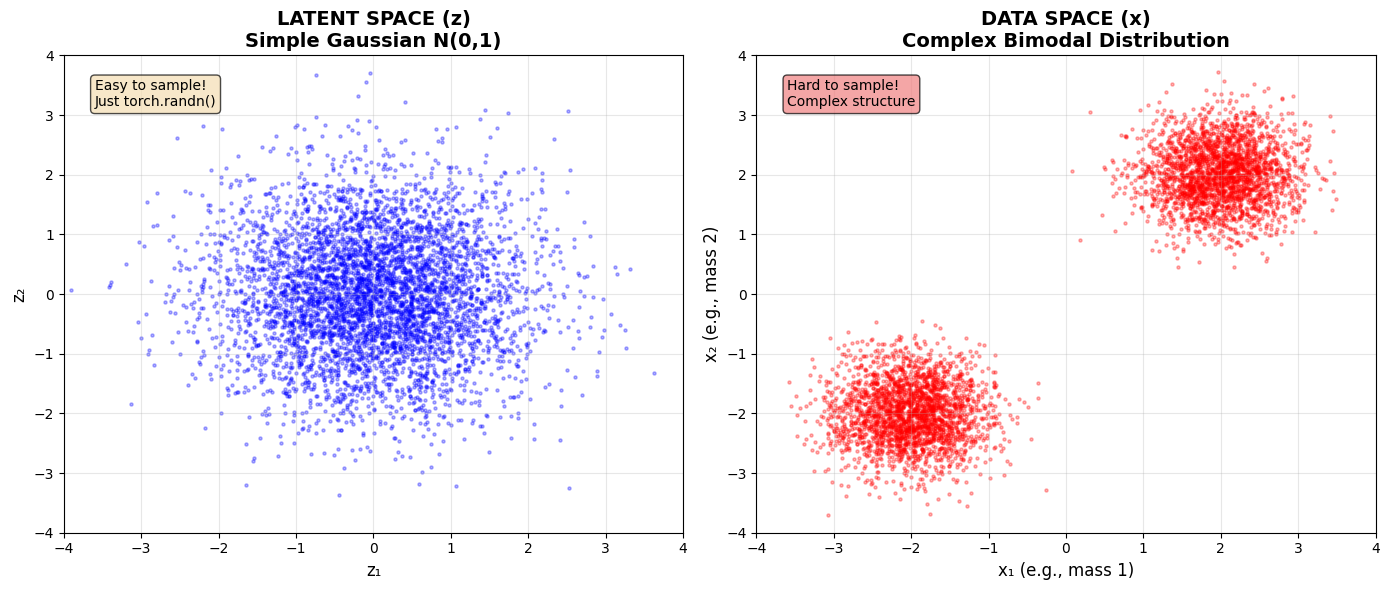


🎯 THE GOAL: Learn to transform LEFT (easy) → RIGHT (complex)


In [5]:
# Generate samples from latent space (simple Gaussian)
latent_samples = torch.randn(5000, 2)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Latent Space (z)
axes[0].scatter(latent_samples[:, 0], latent_samples[:, 1], alpha=0.3, s=5, c='blue')
axes[0].set_title('LATENT SPACE (z)\nSimple Gaussian N(0,1)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('z₁', fontsize=12)
axes[0].set_ylabel('z₂', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(-4, 4)
axes[0].set_ylim(-4, 4)
axes[0].text(0.05, 0.95, 'Easy to sample!\nJust torch.randn()', 
             transform=axes[0].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7),
             fontsize=10)

# Plot 2: Data Space (x)
axes[1].scatter(train_data[:, 0], train_data[:, 1], alpha=0.3, s=5, c='red')
axes[1].set_title('DATA SPACE (x)\nComplex Bimodal Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('x₁ (e.g., mass 1)', fontsize=12)
axes[1].set_ylabel('x₂ (e.g., mass 2)', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(-4, 4)
axes[1].set_ylim(-4, 4)
axes[1].text(0.05, 0.95, 'Hard to sample!\nComplex structure', 
             transform=axes[1].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7),
             fontsize=10)

plt.tight_layout()
plt.show()

print("\n🎯 THE GOAL: Learn to transform LEFT (easy) → RIGHT (complex)")

## Part 5: Train the Flow

Now we train the flow using maximum likelihood estimation.

The goal: maximize `log p(x)` for training samples x.

This is done by:
1. Mapping x back to z (inverse)
2. Computing how "Gaussian-like" z is
3. Adjusting the flow to make z more Gaussian

In [6]:
# Initialize flow
flow = NormalizingFlow(dim=2, n_layers=8, hidden_dim=128)
flow = flow.to(device)

# Optimizer
optimizer = optim.Adam(flow.parameters(), lr=1e-3)

# Training parameters
n_epochs = 100
batch_size = 256

print("\n" + "="*70)
print("TRAINING THE NORMALIZING FLOW")
print("="*70)
print(f"\nModel parameters: {sum(p.numel() for p in flow.parameters()):,}")
print(f"Number of layers: {len(flow.layers)}")
print(f"Training samples: {len(train_data)}")
print(f"Batch size: {batch_size}")
print(f"Epochs: {n_epochs}")

print("\nThe flow is learning to:")
print("  1. Map data space (x) BACK to latent space (z)")
print("  2. Ensure that z looks like a standard Gaussian")
print("  3. This automatically makes forward mapping (z→x) work!\n")

losses = []

for epoch in range(n_epochs):
    epoch_losses = []
    
    # Shuffle data
    perm = torch.randperm(len(train_data))
    train_data_shuffled = train_data[perm]
    
    # Mini-batch training
    for i in range(0, len(train_data), batch_size):
        batch = train_data_shuffled[i:i+batch_size].to(device)
        
        # Compute negative log likelihood
        log_prob = flow.log_prob(batch)
        loss = -log_prob.mean()  # Maximize log prob = minimize negative log prob
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(flow.parameters(), 5.0)
        
        optimizer.step()
        
        epoch_losses.append(loss.item())
    
    avg_loss = np.mean(epoch_losses)
    losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")

print("\n✓ Training complete!")
print(f"  Initial loss: {losses[0]:.4f}")
print(f"  Final loss:   {losses[-1]:.4f}")
print(f"  Improvement:  {losses[0] - losses[-1]:.4f}")
print("\n" + "="*70)


TRAINING THE NORMALIZING FLOW

Model parameters: 274,464
Number of layers: 8
Training samples: 5000
Batch size: 256
Epochs: 100

The flow is learning to:
  1. Map data space (x) BACK to latent space (z)
  2. Ensure that z looks like a standard Gaussian
  3. This automatically makes forward mapping (z→x) work!

Epoch 10/100, Loss: 2.3103
Epoch 20/100, Loss: 2.2550
Epoch 30/100, Loss: 2.2651
Epoch 40/100, Loss: 2.2398
Epoch 50/100, Loss: 2.2273
Epoch 60/100, Loss: 2.2660
Epoch 70/100, Loss: 2.2115
Epoch 80/100, Loss: 2.2327
Epoch 90/100, Loss: 2.1948
Epoch 100/100, Loss: 2.2251

✓ Training complete!
  Initial loss: 5.6411
  Final loss:   2.2251
  Improvement:  3.4160



## Part 6: Test the Trained Flow - Sampling!

Now the magic: sample from simple Gaussian (latent space) and get complex samples (data space)!

In [7]:
# Generate samples using the trained flow
n_test_samples = 5000

print("\n" + "="*70)
print("GENERATING SAMPLES FROM TRAINED FLOW")
print("="*70)

print("\nStep 1: Sample from LATENT SPACE (Gaussian)")
with torch.no_grad():
    z_samples = torch.randn(n_test_samples, 2)
    print(f"  z shape: {z_samples.shape}")
    print(f"  z[:3] = \n{z_samples[:3]}")
    print(f"  z mean: [{z_samples[:, 0].mean():.3f}, {z_samples[:, 1].mean():.3f}]")
    print(f"  z std:  [{z_samples[:, 0].std():.3f}, {z_samples[:, 1].std():.3f}]")

print("\nStep 2: Transform through flow to DATA SPACE")
x_samples = flow.sample(n_test_samples)
print(f"  x shape: {x_samples.shape}")
print(f"  x[:3] = \n{x_samples[:3]}")
print(f"  x mean: [{x_samples[:, 0].mean():.3f}, {x_samples[:, 1].mean():.3f}]")
print(f"  x std:  [{x_samples[:, 0].std():.3f}, {x_samples[:, 1].std():.3f}]")

print("\n✓ Generated 5000 samples in milliseconds!")
print("\n" + "="*70)


GENERATING SAMPLES FROM TRAINED FLOW

Step 1: Sample from LATENT SPACE (Gaussian)
  z shape: torch.Size([5000, 2])
  z[:3] = 
tensor([[2.1162, 1.2091],
        [1.3005, 0.0643],
        [1.0610, 0.7191]])
  z mean: [0.014, 0.018]
  z std:  [1.005, 0.989]

Step 2: Transform through flow to DATA SPACE
  x shape: torch.Size([5000, 2])
  x[:3] = 
tensor([[ 1.5326,  1.8470],
        [ 2.6546,  1.7807],
        [-1.1127, -1.5754]])
  x mean: [-0.071, -0.056]
  x std:  [2.143, 2.165]

✓ Generated 5000 samples in milliseconds!



## Part 7: Visualize Results

Compare the true distribution with samples from our trained flow!

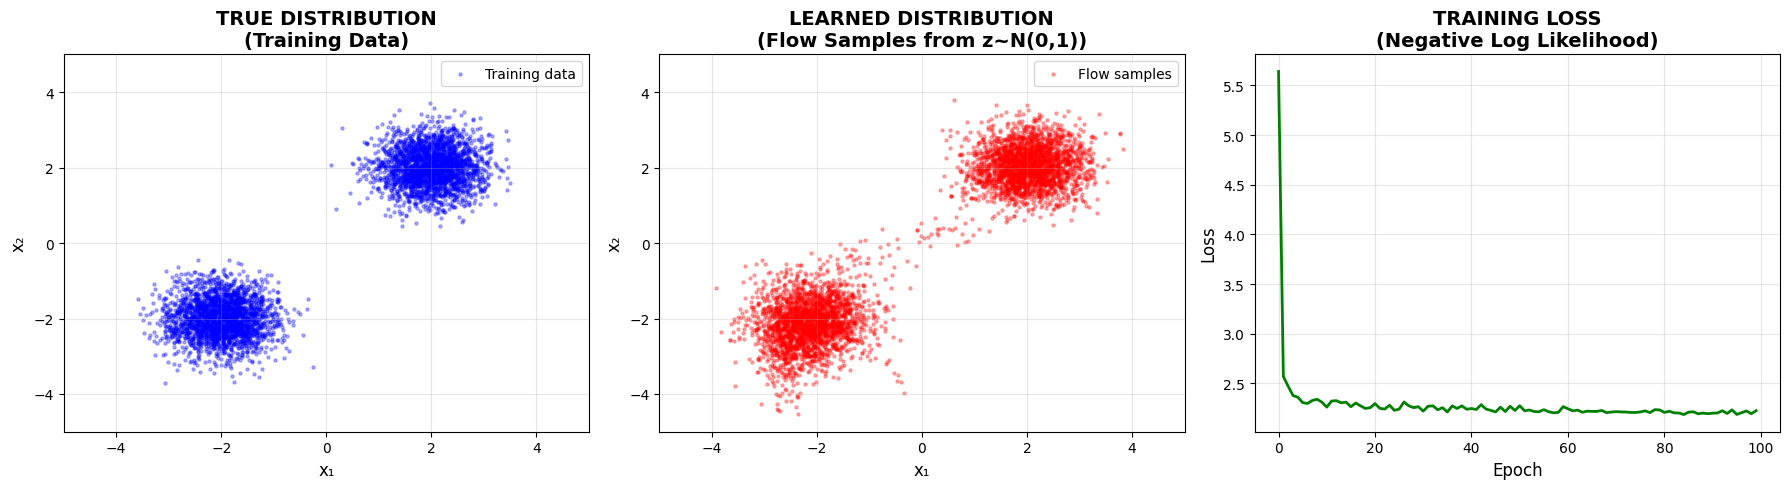


🎉 SUCCESS! The flow learned to transform Gaussian → Bimodal distribution!

Compare the left and middle plots - they should look very similar!


In [8]:
fig = plt.figure(figsize=(18, 5))

# Plot 1: True data distribution
ax1 = plt.subplot(1, 3, 1)
ax1.scatter(train_data[:, 0].numpy(), train_data[:, 1].numpy(), 
            alpha=0.3, s=5, c='blue', label='Training data')
ax1.set_title('TRUE DISTRIBUTION\n(Training Data)', fontsize=14, fontweight='bold')
ax1.set_xlabel('x₁', fontsize=12)
ax1.set_ylabel('x₂', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-5, 5)
ax1.set_ylim(-5, 5)
ax1.legend()

# Plot 2: Samples from trained flow
ax2 = plt.subplot(1, 3, 2)
ax2.scatter(x_samples[:, 0].numpy(), x_samples[:, 1].numpy(), 
            alpha=0.3, s=5, c='red', label='Flow samples')
ax2.set_title('LEARNED DISTRIBUTION\n(Flow Samples from z~N(0,1))', 
              fontsize=14, fontweight='bold')
ax2.set_xlabel('x₁', fontsize=12)
ax2.set_ylabel('x₂', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-5, 5)
ax2.set_ylim(-5, 5)
ax2.legend()

# Plot 3: Training loss
ax3 = plt.subplot(1, 3, 3)
ax3.plot(losses, linewidth=2, color='green')
ax3.set_title('TRAINING LOSS\n(Negative Log Likelihood)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Loss', fontsize=12)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🎉 SUCCESS! The flow learned to transform Gaussian → Bimodal distribution!")
print("\nCompare the left and middle plots - they should look very similar!")

## Part 8: Demonstrate Latent Space Mapping

Let's explicitly show how specific points in latent space map to data space.

In [9]:
# Pick specific points in latent space
test_points_z = torch.tensor([
    [-1.5, 0.8],   # Left side of Gaussian
    [1.2, -0.9],   # Right side of Gaussian
    [0.0, 0.0],    # Center of Gaussian
    [-2.0, -1.0],  # Far left
    [1.5, 1.2],    # Far right
])

# Transform to data space
with torch.no_grad():
    test_points_x, _ = flow.forward(test_points_z)

print("\n" + "="*70)
print("LATENT SPACE (z) → DATA SPACE (x) MAPPING")
print("="*70 + "\n")

for i, (z, x) in enumerate(zip(test_points_z, test_points_x)):
    print(f"Point {i+1}:")
    print(f"  z = [{z[0]:6.2f}, {z[1]:6.2f}]  →  x = [{x[0]:6.2f}, {x[1]:6.2f}]")
    
    # Determine which mode
    if x[0] < 0:
        print(f"  (maps to LEFT mode)")
    else:
        print(f"  (maps to RIGHT mode)")
    print()

print("="*70)
print("\n✨ Key Insight: Different z values produce different x values!")
print("This is how we generate diverse samples from the posterior.")
print("\nIn DINGO: Different random z → Different GW parameter samples")


LATENT SPACE (z) → DATA SPACE (x) MAPPING

Point 1:
  z = [ -1.50,   0.80]  →  x = [ -2.85,  -2.49]
  (maps to LEFT mode)

Point 2:
  z = [  1.20,  -0.90]  →  x = [  2.65,   2.07]
  (maps to RIGHT mode)

Point 3:
  z = [  0.00,   0.00]  →  x = [  2.11,   1.04]
  (maps to RIGHT mode)

Point 4:
  z = [ -2.00,  -1.00]  →  x = [ -2.45,  -3.30]
  (maps to LEFT mode)

Point 5:
  z = [  1.50,   1.20]  →  x = [  1.99,   2.86]
  (maps to RIGHT mode)


✨ Key Insight: Different z values produce different x values!
This is how we generate diverse samples from the posterior.

In DINGO: Different random z → Different GW parameter samples


## Part 9: Visualize the Mapping

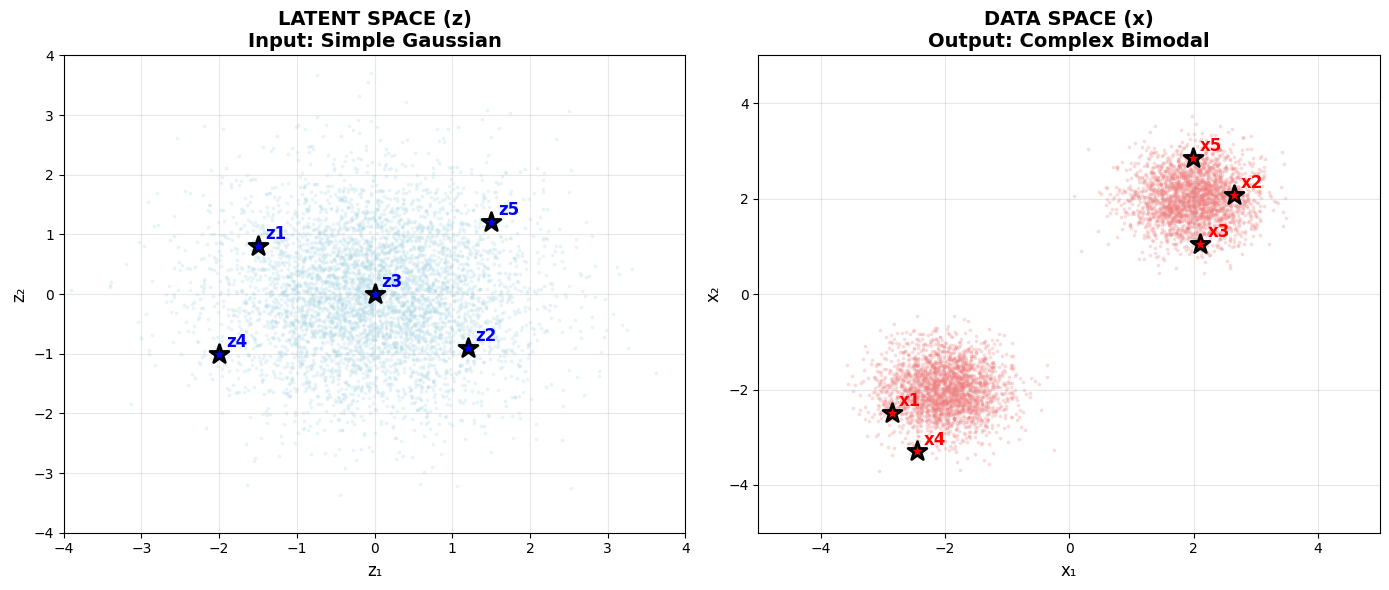


⭐ Each star shows a specific point in latent space (left)
   and where it maps to in data space (right)!


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Latent space with test points
axes[0].scatter(latent_samples[:, 0], latent_samples[:, 1], 
                alpha=0.2, s=3, c='lightblue')
axes[0].scatter(test_points_z[:, 0].numpy(), test_points_z[:, 1].numpy(), 
                s=200, c='blue', marker='*', edgecolors='black', linewidths=2, zorder=5)
for i, (z, x) in enumerate(zip(test_points_z, test_points_x)):
    axes[0].annotate(f'z{i+1}', xy=(z[0], z[1]), xytext=(5, 5), 
                     textcoords='offset points',
                     fontsize=12, fontweight='bold', color='blue')
axes[0].set_title('LATENT SPACE (z)\nInput: Simple Gaussian', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('z₁', fontsize=12)
axes[0].set_ylabel('z₂', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(-4, 4)
axes[0].set_ylim(-4, 4)

# Right: Data space with mapped points
axes[1].scatter(train_data[:, 0].numpy(), train_data[:, 1].numpy(), 
                alpha=0.2, s=3, c='lightcoral')
axes[1].scatter(test_points_x[:, 0].numpy(), test_points_x[:, 1].numpy(), 
                s=200, c='red', marker='*', edgecolors='black', linewidths=2, zorder=5)
for i, (z, x) in enumerate(zip(test_points_z, test_points_x)):
    axes[1].annotate(f'x{i+1}', xy=(x[0], x[1]), xytext=(5, 5), 
                     textcoords='offset points',
                     fontsize=12, fontweight='bold', color='red')
axes[1].set_title('DATA SPACE (x)\nOutput: Complex Bimodal', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('x₁', fontsize=12)
axes[1].set_ylabel('x₂', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(-5, 5)
axes[1].set_ylim(-5, 5)

plt.tight_layout()
plt.show()

print("\n⭐ Each star shows a specific point in latent space (left)")
print("   and where it maps to in data space (right)!")

## Part 10: Compute and Visualize Probability Density

One superpower of normalizing flows: we can compute exact probabilities!

Computing probability density over grid...


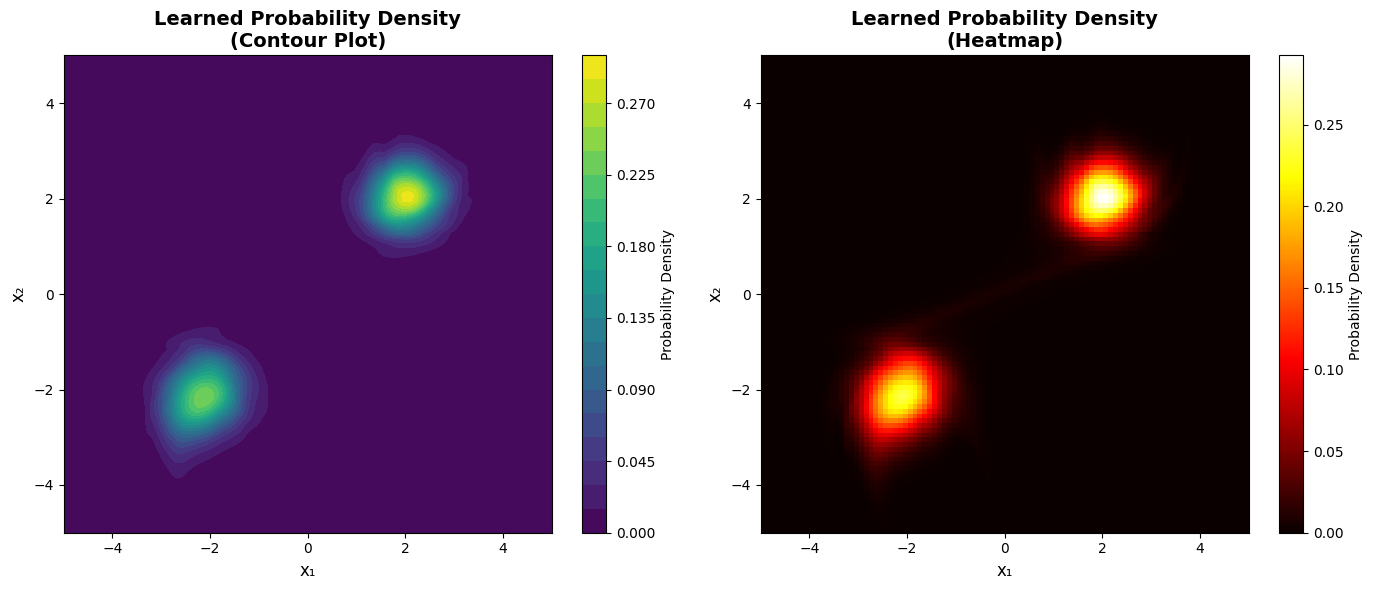


✓ Probability density clearly shows two modes!
   Brighter regions = higher probability


In [11]:
# Create a grid for probability computation
x_range = np.linspace(-5, 5, 100)
y_range = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x_range, y_range)
pos = np.stack([X, Y], axis=-1)
pos_flat = torch.FloatTensor(pos.reshape(-1, 2))

# Compute log probabilities
print("Computing probability density over grid...")
with torch.no_grad():
    log_probs = flow.log_prob(pos_flat)
    probs = torch.exp(log_probs).numpy().reshape(100, 100)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Contour plot
im1 = axes[0].contourf(X, Y, probs, levels=20, cmap='viridis')
axes[0].set_title('Learned Probability Density\n(Contour Plot)', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('x₁', fontsize=12)
axes[0].set_ylabel('x₂', fontsize=12)
plt.colorbar(im1, ax=axes[0], label='Probability Density')

# Heatmap
im2 = axes[1].imshow(probs, extent=[-5, 5, -5, 5], origin='lower', 
                      cmap='hot', aspect='auto')
axes[1].set_title('Learned Probability Density\n(Heatmap)', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('x₁', fontsize=12)
axes[1].set_ylabel('x₂', fontsize=12)
plt.colorbar(im2, ax=axes[1], label='Probability Density')

plt.tight_layout()
plt.show()

print("\n✓ Probability density clearly shows two modes!")
print("   Brighter regions = higher probability")

## Summary: Key Takeaways About Latent Space

### What is Latent Space?
**Latent space (z)** is a simple, structured space (standard Gaussian) that serves as the starting point for the normalizing flow.

### Why Use It?
1. **Easy to sample**: Just `torch.randn()` - instant random samples!
2. **Structured**: Simple Gaussian N(0,1) - we know everything about it
3. **Transforms to complex**: Flow learns to map z → complex distributions
4. **Same dimensionality**: Not compression - transformation (2D → 2D)

### The Flow's Job:
Learn an invertible transformation:
- **Forward**: z (Gaussian) → x (complex distribution)
- **Inverse**: x (complex) → z (Gaussian)

### The Training Process:
```
1. Take training sample x from target distribution
2. Map back to latent space: z = flow.inverse(x)
3. Check if z looks Gaussian: log p(z)
4. Adjust flow parameters to make z more Gaussian
5. Repeat for all training samples
```

### After Training:
```python
z = torch.randn(1000, 2)  # Sample from latent space
x = flow(z)                # Transform to data space
# x now contains 1000 samples from learned distribution!
```

### In DINGO (Gravitational Waves):
- **z**: Random Gaussian numbers (15D) - the "latent space"
- **x = θ**: Physical GW parameters (masses, spins, distance, etc.)
- **Flow**: Transforms z → θ conditioned on observed strain data
- **Result**: 1 second inference vs. 6 hours of MCMC!

### The Magic:
```python
# Traditional way (SLOW)
run_mcmc_for_6_hours()  # ⏰ Very slow!

# With normalizing flows (FAST)
z = torch.randn(10000, 15)    # Sample latent space
theta = flow(z, data=strain)  # Transform to posteriors
# Done in 1 second! ⚡
```

### Key Properties:
1. **Invertibility**: Can go both directions (z↔x)
2. **Exact probabilities**: Can compute p(x) exactly
3. **Fast sampling**: Just forward pass through network
4. **Flexible**: Can model complex, multimodal distributions

### Bottom Line:
**Latent space is the "source of randomness" - different random z values produce different samples from your complex posterior distribution, all through a learned transformation that preserves probabilities!**